In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Dense,Input
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import Flatten, Activation,LeakyReLU,Concatenate,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.initializers import RandomNormal 
from numpy import random
from tensorflow.keras.utils import plot_model

In [2]:
def define_discriminator(image_shape):

  init=RandomNormal(stddev=0.02)

  in_src_image=Input(shape=image_shape)
  in_target_image=Input(shape=image_shape)

  merged=Concatenate()([in_src_image,in_target_image])
  
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  
  model = Model([in_src_image, in_target_image], patch_out)
  
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


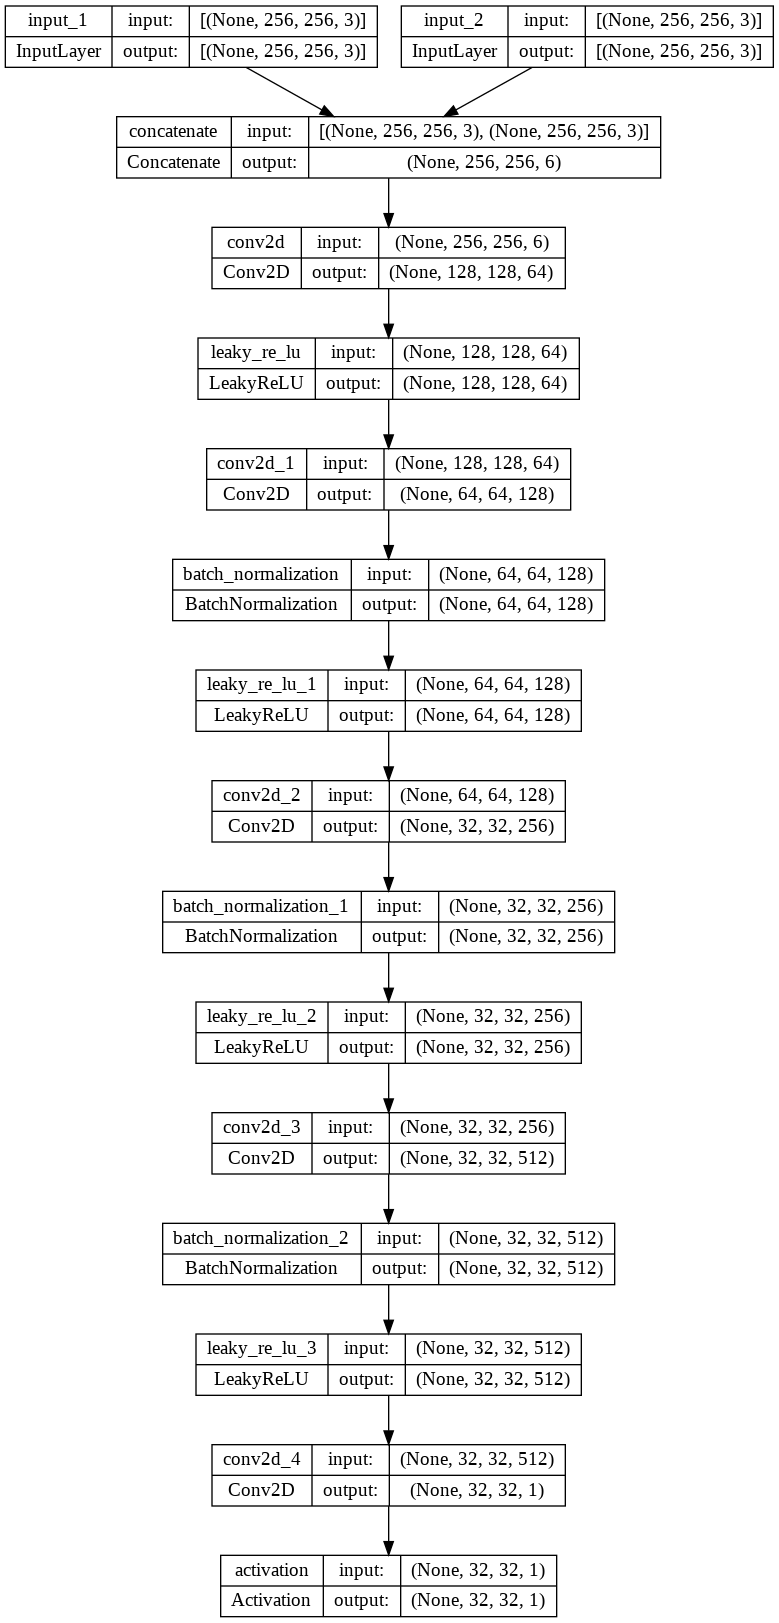

In [3]:
disc_model = define_discriminator((256,256,3))
plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

In [4]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  init = RandomNormal(stddev=0.02)
  
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  
  if batchnorm:
    g = BatchNormalization()(g, training=True)
    
  g = LeakyReLU(alpha=0.2)(g)
  return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  
  init = RandomNormal(stddev=0.02)
  
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g, training=True)
  
  if dropout:
    g = Dropout(0.5)(g, training=True)
    
  g = Concatenate()([g, skip_in])
  g = Activation('relu')(g)
  return g


def define_generator(image_shape=(256,256,3)):
  
  init = RandomNormal(stddev=0.02)
  
  in_image = Input(shape=image_shape)
  
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  
  g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)  
  
  model = Model(in_image, out_image)
  return model

In [5]:
def define_gan(g_model, d_model, image_shape):
  
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
      
  in_src = Input(shape=image_shape)
  
  gen_out = g_model(in_src)
  
  dis_out = d_model([in_src, gen_out])
  
  model = Model(in_src, [dis_out, gen_out])
  
  opt = Adam(lr=0.0002, beta_1=0.5)
  
  model.compile(loss=['binary_crossentropy', 'mae'],optimizer=opt, loss_weights=[1,100])
  return model

In [6]:
def generate_real_samples(dataset, n_samples, patch_shape):
  trainA, trainB = dataset
  
  ix = random.randint(0, trainA.shape[0], n_samples)
  
  X1, X2 = trainA[ix], trainB[ix]
  y =np.ones((n_samples, patch_shape, patch_shape, 1))
  
  return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
  
  X = g_model.predict(samples)
  y =np.zeros((len(X), patch_shape, patch_shape, 1))
  
  return X, y

In [7]:
def summarize_performance(step, g_model, dataset, n_samples=3):
  
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_realA[i])
    
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
    
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_realB[i])
    
  filename1 = 'plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()
  
  filename2 = 'model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [8]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  
  n_patch = d_model.output_shape[1]
  
  trainA, trainB = dataset
  
  bat_per_epo = int(len(trainA) / n_batch)
  n_steps = bat_per_epo * n_epochs
  
  for i in range(n_steps):
    
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    if (i+1) % (bat_per_epo) == 0:
      summarize_performance(i, g_model, dataset)